# Cad: Usd Exchange Rate Prediction (Based on data from 2007-2018)

for TRY Conference (2018) 
by Josephine Choi and Lei Jin 


## Background

This Jupyter  Notebook is created based on webposts by Illiya Valchanov / Rohit Garg 

Illiya Valchanov 
https://datascienceplus.com/how-to-apply-monte-carlo-simulation-to-forecast-stock-prices-using-python/ (Dec 2017) 

Rohit Garg 
https://analyticsindiamag.com/a-primer-to-monte-carlo-simulation-in-python/ (Mar 2018)

The original code is for building a monte carlo simulation model for stock pricing 

The following YouTube video are helpful in understanding monte carlo simulation 

Understanding and creating Monte Carlo Simulation Step by Step 
https://www.youtube.com/watch?v=3gcLRU24-w0



In [33]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
import numpy as np
from scipy.stats import norm

## Step 1: Loading the data into Python

- Daily exchange rate data can be found through Bank of Canada website
- As part of the preprocessing, files were downloaded yearly and need to be combined
- Data might be also available through REST API (e.g. quandl) 



In [34]:
Ex2012 = pd.read_excel("data/Ex2012.xlsx",parse_dates=True,index_col=0)
Ex2013 = pd.read_csv("data/Ex2013.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2014 = pd.read_csv("data/Ex2014.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2015 = pd.read_csv("data/Ex2015.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2016 = pd.read_csv("data/Ex2016.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2017 = pd.read_csv("data/Ex2017.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2018 = pd.read_csv("data/Ex2018.csv",skiprows=8,parse_dates=True,index_col=0)

Ex2011 = pd.read_csv("data/Ex2011.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2010 = pd.read_csv("data/Ex2010.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2009 = pd.read_csv("data/Ex2009.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2008 = pd.read_csv("data/Ex2008.csv",skiprows=8,parse_dates=True,index_col=0)
Ex2007 = pd.read_csv("data/Ex2007.csv",skiprows=8,parse_dates=True,index_col=0)


Ex = Ex2007.append(Ex2008).append(Ex2009).append(Ex2010).append(Ex2011).append(Ex2012).append(Ex2013).append(Ex2014).append(Ex2015).append(Ex2016).append(Ex2017).append(Ex2018)
Ex.sample(5)


,IEXE0101
date,
2008-08-05 00:00:00,1.0426
2011-05-31 00:00:00,0.9688
2007-05-22 00:00:00,1.0855
2015-12-17,1.3970
2018-01-05 00:00:00,1.2403



## Step 2: Inspect the data and Cleaning the data for model

- Unlike spreadsheet tools like Excel, data inspection through statistics tools (e.g. R) or programming language (e.g. Python) do not rely on visual inspection
- Here are some of the commands that are useful for inspecting data in python 
  * df.describe()
  * df.sample()
  * df.info()
- Remove erroneous data 
- Missing data can be filled with a) mean b) mode c) backfilling or forward filling 
- Make sure the data types were set up correctly
- Inspect the data again before moving forward to the next stage 


In [35]:
Ex.describe()
Ex.sample(20)
Ex['date']=Ex.index.values


#Don't know whether these were coming from 

Ex=Ex[Ex.date!='ERROR']
Ex=Ex[Ex.date!='date']
Ex=Ex[Ex.IEXE0101 != -64]
Ex=Ex[Ex.IEXE0101 != '-64']

# Opted to fill the bank holiday (empty fields) with forward filling (ffill). Back filling should do the trick as well 
Ex.IEXE0101=Ex['IEXE0101'].fillna(method="ffill")
Ex["IEXE0101"]=Ex["IEXE0101"].fillna(1)

#Set the type to the correct type 
Ex['IEXE0101'] = Ex['IEXE0101'].astype('float')

Ex['date'] = Ex['date'].astype('datetime64[ns]')

#for some strange reason, there were dates >2019, and thus needs to be removed

Ex=Ex[Ex.date<'2019-01-01']
#Ex.date = Ex.date.apply(pd.to_datetime, format='%d/%m/%Y')
Ex.sort_values(by=['date'])
Ex.set_index(Ex.date,inplace=True)


Ex=Ex.drop('date', axis=1)
#Ex.index=Ex['date']



In [36]:
Ex.info()

print("-"*40)

Ex.describe()
#Ex.drop('date',axis=1)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2777 entries, 2007-05-01 to 2018-03-15
Data columns (total 1 columns):
IEXE0101    2777 non-null float64
dtypes: float64(1)
memory usage: 43.4 KB
----------------------------------------


,IEXE0101
count,2777.000000
mean,1.123416
std,0.130128
min,0.917000
25%,1.015600
50%,1.067100
75%,1.253300
max,1.458900


## Step 3: Building the financial model

- Inspect the general trend of existing data 
- We see gradual growth over the past five years
- Five years of past data may not be enough: Model may be biased because of the past performance 


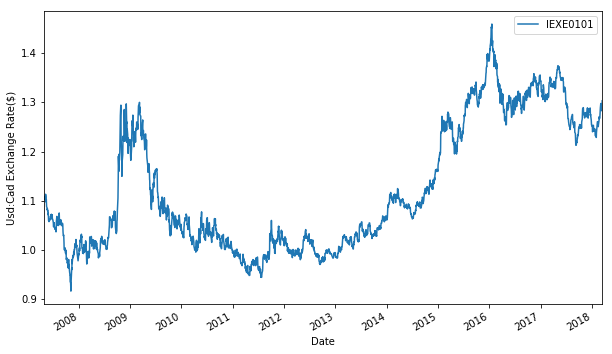

In [37]:

log_returns = np.log(1 + Ex['IEXE0101'].pct_change())
log_returns.tail()

type(log_returns)

Ex.plot(figsize=(10,6))
plt.ylabel("Usd:Cad Exchange Rate($)")
plt.xlabel("Date")
plt.show();


- Plotting the log returns

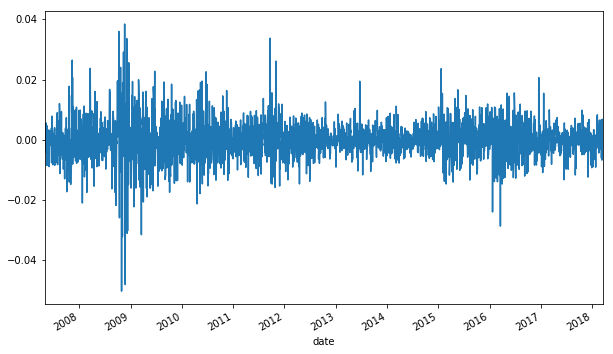

In [38]:
log_returns.plot(figsize=(10,6));

### Finding out the variables required for the calculation of Brownian motion 
- Brownian motion : the formula was first used to model random movement in physics. But has been used to predict the movement of an asset in finance  
- Brownian motion assumes two part of the random movement
  * drift(a constant driving force)
  * random stochastic component(random component) 
- We need 
  * mean 
  * variance (historical volatility) 


In [39]:
u=log_returns.mean()
u
type(u)

float

In [40]:
var=log_returns.var()
var

4.036247883722143e-05

- Brownian motion assumes two parts of movement 
- Drift is the expected rate of return 
- Today's price = Yesterday's price * e ** r
- For standard Monte Carlo : average of historical return - (variance/2) 
- There are other theories are what the drift would be 
 * risk free rate - (variance/2)
 * 0 (supported by random walk theory) 
 



In [41]:
drift=u-(0.5*var)
drift

3.7979511780476366e-05

In [42]:
stdev = log_returns.std()
stdev

0.006353147160047643

In [43]:
#type(drift)
#type(stdev)

In [44]:
drift=np.array(drift)
#type(drift)

In [45]:
#stdev=np.array(stdev)
#type(stdev)
#drift.values
#stdev.values
#norm.ppf(0.95)

For the random component, we need to randomize. This can be done by numpy "rand" function. As an example, the following code will create a multidimensional array


In [46]:
x=np.random.rand(10,2)
x
norm.ppf(x)

array([[-0.63008664, -0.20855393],
       [ 1.98592343,  0.21081143],
       [-1.95163324,  0.32315448],
       [ 0.86537794, -0.58221868],
       [ 1.03022953, -1.07217134],
       [ 0.32557718,  0.38312985],
       [ 0.62274414, -0.56797198],
       [ 0.88453359,  1.65085394],
       [-1.64492659, -0.26258089],
       [ 0.60536689, -0.05061437]])

In [47]:
Z=norm.ppf(np.random.rand(10,2))
Z

array([[ 1.77269602, -0.10199698],
       [ 0.47928146, -2.20963587],
       [ 1.88799064,  0.50613421],
       [ 0.56339982,  0.37628306],
       [ 0.20124375,  0.60330599],
       [ 0.73751496, -1.11387083],
       [-0.66595609,  0.79587953],
       [-0.4294997 ,  0.37708108],
       [ 0.66196339, -1.04053195],
       [-0.79425211,  1.4335629 ]])

The following code set the number of iterations (the number of trials) and t_intervals (the length of projection)  

In [48]:
t_intervals=1000
iterations=500

This is the formula we used to build our model 
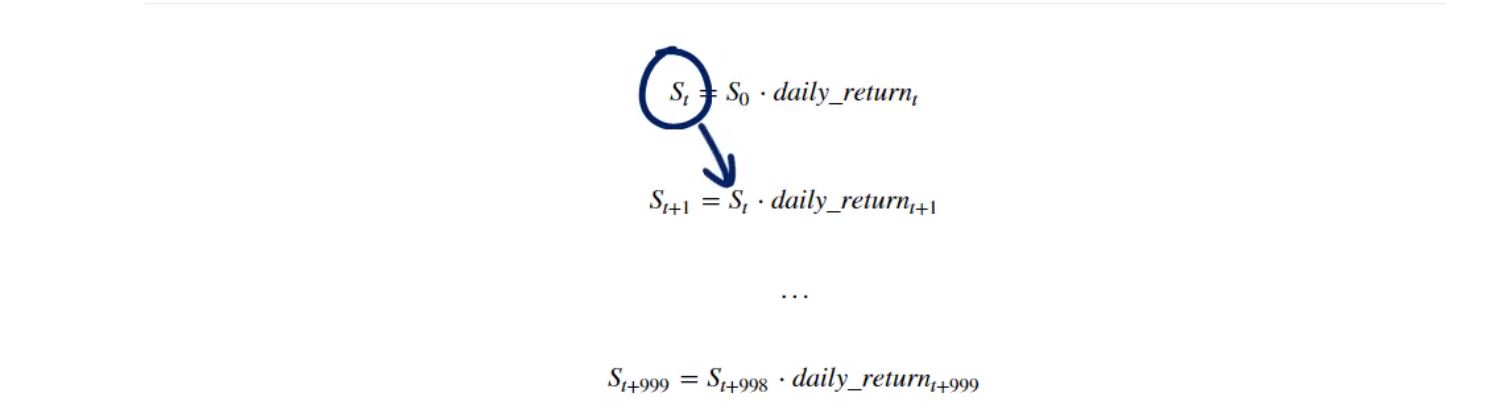

In [49]:
daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(t_intervals, iterations)))

In [50]:
type(daily_returns)

numpy.ndarray

In [51]:
S0=Ex.iloc[-1,0]
S0

1.3031999999999999

In [52]:
price_list=np.zeros_like(daily_returns)

In [53]:
price_list

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [54]:
price_list[0]=S0
price_list

array([[ 1.3032,  1.3032,  1.3032, ...,  1.3032,  1.3032,  1.3032],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       ..., 
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ]])

In [55]:
for t in range(1,t_intervals):
    price_list[t]=price_list[t-1]*daily_returns[t]

In [56]:
price_list


array([[ 1.3032    ,  1.3032    ,  1.3032    , ...,  1.3032    ,
         1.3032    ,  1.3032    ],
       [ 1.29110123,  1.29518398,  1.29781088, ...,  1.30347348,
         1.30766443,  1.30780621],
       [ 1.27696931,  1.29264169,  1.30919197, ...,  1.28967126,
         1.31983625,  1.30285232],
       ..., 
       [ 1.00794597,  1.30904639,  1.55431009, ...,  1.40383986,
         1.68753113,  1.1161656 ],
       [ 1.00774365,  1.30303091,  1.54387998, ...,  1.4085871 ,
         1.68489029,  1.10471219],
       [ 1.0138724 ,  1.30282414,  1.53632194, ...,  1.39014425,
         1.69573496,  1.10276199]])

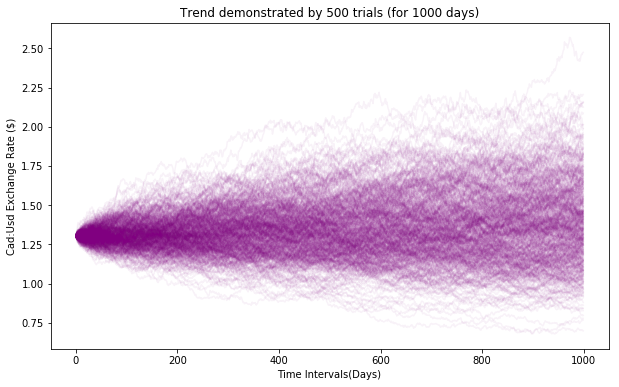

In [57]:
plt.figure(figsize=(10,6));
plt.plot(price_list,color="purple",alpha=0.05);
plt.xlabel("Time Intervals(Days)")
plt.ylabel("Cad:Usd Exchange Rate ($)")
plt.title("Trend demonstrated by 500 trials (for 1000 days)");

In [58]:
price_list.shape

prediction=pd.DataFrame(price_list)
prediction.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,...,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200,1.303200
1,1.291101,1.295184,1.297811,1.314597,1.304531,1.318253,1.306666,1.297155,1.295409,1.294301,...,1.297721,1.296986,1.298145,1.301998,1.314499,1.311299,1.304433,1.303473,1.307664,1.307806
2,1.276969,1.292642,1.309192,1.324426,1.302159,1.309592,1.309419,1.307015,1.295759,1.285488,...,1.278952,1.293833,1.292057,1.298104,1.304410,1.308131,1.299843,1.289671,1.319836,1.302852
3,1.274469,1.287947,1.302200,1.312334,1.297050,1.312858,1.305624,1.295290,1.295934,1.289899,...,1.258959,1.284707,1.290897,1.298428,1.303332,1.314869,1.287768,1.279627,1.314668,1.307647
4,1.275344,1.279864,1.301989,1.306124,1.303704,1.316926,1.309252,1.291641,1.295543,1.279487,...,1.257586,1.299416,1.293077,1.294561,1.307178,1.319650,1.276160,1.298038,1.311969,1.299245


## Step 4: Analysis 

 - The Monte Carlo simulation allows us to speculate the foreign exchange rate based on a selected timeframe. 
 - It is different from a regular projection because we can now quantify probability. This was made possible by central limit theorum 
 

### Central Limit Theorum 
- if we graph enough periodical daily returns of an asset, the graph should form a normal distribution, bell shaped graph

TP = YS * e ** r
TP = Tomorrow's stock price 
S = Today's stock price 
r = periodical daily rate of return


## Prediction

### 3 Months from start date (Mar 15th 2018)

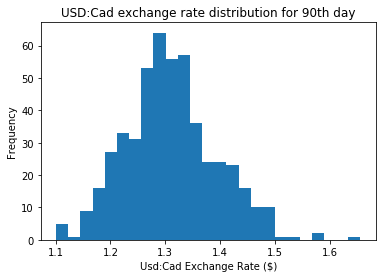

The mean for 90th day distribution is 1.311043
Probability of exchange rate over 1.4 after 90 days: 15 percent
----------------------------------------
Prediction details are as follow:


count    500.000000
mean       1.311043
std        0.082610
min        1.100766
25%        1.257208
50%        1.305381
75%        1.357169
max        1.655836
Name: 90, dtype: float64

In [59]:
pred90=prediction.iloc[90,:]
mean90=pred90.mean()

pred1=prediction.iloc[90,:]>1.4
prob=pred1.sum()/500 *100

plt.hist(pred90,bins=25)
plt.ylabel("Frequency")
plt.xlabel("Usd:Cad Exchange Rate ($)")
plt.title("USD:Cad exchange rate distribution for 90th day");
plt.show()



print("The mean for 90th day distribution is %f" %(mean90))
print( "Probability of exchange rate over 1.4 after 90 days: %d percent" %(prob))

print("-"*40)

print("Prediction details are as follow:")
prediction.iloc[90,:].describe()

### One month from start date 

0.332181711385


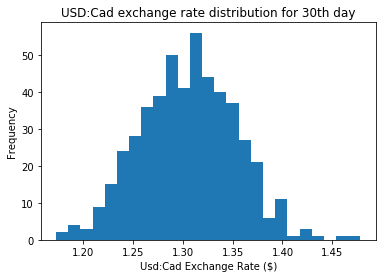

The mean for 30th day distribution is 1.305610
Probability of exchange rate over 1.25 after 30 days: 87 percent
----------------------------------------
Prediction details are as follow:


count    500.000000
mean       1.305610
std        0.047865
min        1.173342
25%        1.272027
50%        1.307037
75%        1.339461
max        1.478012
Name: 30, dtype: float64

In [60]:
pred30=prediction.iloc[30,:]

mean30=pred30.mean()

pred2=prediction.iloc[30,:]>1.25 
std1=pred2.std()
print(std1)

plt.hist(pred30,bins=25)
plt.ylabel("Frequency")
plt.xlabel("Usd:Cad Exchange Rate ($)")
plt.title("USD:Cad exchange rate distribution for 30th day");
plt.show()


prob=pred2.sum()/500 *100

print("The mean for 30th day distribution is %f" %(mean30))

print( "Probability of exchange rate over 1.25 after 30 days: %d percent" %(prob))

print("-"*40)

print("Prediction details are as follow:")
prediction.iloc[30,:].describe()

### 6 months from start date 

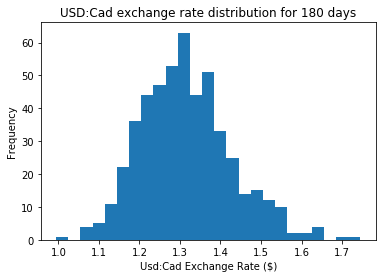

The mean for 180th day distribution is 1.315990
Probability of exchange rate over 1.4 after 180 days: 21 percent
----------------------------------------
Prediction details are as follow:


count    500.000000
mean       1.315990
std        0.112236
min        0.994177
25%        1.239752
50%        1.306507
75%        1.380013
max        1.745370
Name: 180, dtype: float64

In [61]:
pred180=prediction.iloc[180,:]
mean180=pred180.mean()

pred2=prediction.iloc[180,:]>1.4


plt.hist(pred180,bins=25)
plt.ylabel("Frequency")
plt.xlabel("Usd:Cad Exchange Rate ($)")
plt.title("USD:Cad exchange rate distribution for 180 days");
plt.show()


prob=pred2.sum()/500 *100

print("The mean for 180th day distribution is %f" %(mean180))

print( "Probability of exchange rate over 1.4 after 180 days: %d percent" %(prob))

print("-"*40)

print("Prediction details are as follow:")
prediction.iloc[180,:].describe()

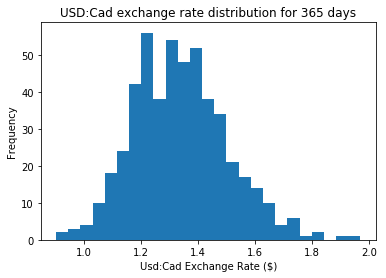

The mean for 365th day distribution is 1.336763
Probability of exchange rate over 1.4 after 365 days: 32 percent
Probability of exchange rate less than 1.31 after 365 days: 45 percent
----------------------------------------
Prediction details are as follow:


count    500.000000
mean       1.336763
std        0.165464
min        0.901116
25%        1.217824
50%        1.326310
75%        1.439155
max        1.968731
Name: 365, dtype: float64

In [62]:
pred365=prediction.iloc[365,:]

mean365= prediction.iloc[365,:].mean()

pred3=prediction.iloc[365,:]>1.4
pred2=prediction.iloc[365,:]<1.31
prob1 =(pred3.sum()/500) *100
prob2=(pred2.sum()/500)*100

plt.hist(pred365,bins=25)
plt.ylabel("Frequency")
plt.xlabel("Usd:Cad Exchange Rate ($)")
plt.title("USD:Cad exchange rate distribution for 365 days");
plt.show()

print("The mean for 365th day distribution is %f" %(mean365))
print( "Probability of exchange rate over 1.4 after 365 days: %d percent" %(prob1)) 
print( "Probability of exchange rate less than 1.31 after 365 days: %d percent" %(prob2)) 

print("-"*40)

print("Prediction details are as follow:")
prediction.iloc[365,:].describe()
